In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import os
import time

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
batch_size = 32
num_classes = 15
epochs = 100
image_size = (128,128)

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_kaggle_cnn_trained_model.h5'

In [3]:
print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
# datagen = ImageDataGenerator(
#     rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
#     width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#     height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#     horizontal_flip=True,  # randomly flip images
#     vertical_flip=False)  # randomly flip images

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#         shear_range=0.2,
#         zoom_range=0.2,
    horizontal_flip=True,  # randomly flip images
    validation_split=0.2,
    vertical_flip=False
    )

train_generator = train_datagen.flow_from_directory(
        'train',
        shuffle=True,
        seed=1,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')


Using real-time data augmentation.
Found 2393 images belonging to 15 classes.


In [4]:
valid_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = train_datagen.flow_from_directory(
        'train',
        shuffle=False,
        seed=1,
        target_size=image_size,
        batch_size=1,
        class_mode='categorical',
        subset='validation')

Found 593 images belonging to 15 classes.


i.shape=  (32, 128, 128, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


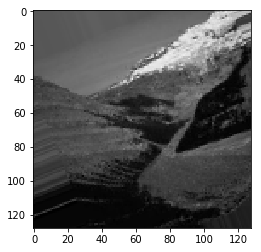

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
i,l = next(train_generator)
print('i.shape= ', i.shape)
print(l[0])
ax = plt.imshow(i[0])

In [6]:
print(train_generator.n)

2393


In [7]:
# The data, shuffled and split between train and test sets:
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
# print('x_train shape:', x_train.shape)
# print(x_train.shape[0], 'train samples')
# print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)
# build our CNN model

print('train shape:', image_size)
print(train_generator.n, 'train samples')
print(validation_generator.n, 'test samples')
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(image_size[0], image_size[1],3) ))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

print(model.summary())

# initiate Adam optimizer
opt = keras.optimizers.Adam()

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train /= 255.
# x_test /= 255.


# Use ModelCheckpoint to save model and weights
if os.path.exists(save_dir):
    timestamp = 'saved_models_{:d}'.format(int(time.time()))
    print("file or directory with the name of ", save_dir, ' exists. use modified name : ', timestamp)
    save_dir = os.path.join(os.getcwd(), timestamp)
    os.makedirs(save_dir)
else:
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)

# earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Fit the model on the batches generated by datagen.flow().
# model_history = model.fit_generator(datagen.flow(x_train, x_train,
#                                  batch_size=batch_size),
#                     epochs=epochs,
#                     validation_data=(x_test, y_test),
#                     workers=4,
#                     callbacks=[earlystop,checkpoint])
STEPS_PER_EPOCH = train_generator.n // train_generator.batch_size
VALIDATION_STEP = validation_generator.n // validation_generator.batch_size
print('STEPS_PER_EPOCH = ', STEPS_PER_EPOCH)
print('VALIDATION_STEP = ', VALIDATION_STEP)
model_history = model.fit_generator(
                                    generator=train_generator,
                                    steps_per_epoch = STEPS_PER_EPOCH,
                                    validation_data = validation_generator, 
                                    validation_steps = VALIDATION_STEP,
                                    callbacks=[earlystop,checkpoint],
                                    workers=4,
                                    epochs = epochs
                                    )


train shape: (128, 128)
2393 train samples
593 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 128)       0         
_________________________________________________________________
max_pooling2d_2 

NameError: name 'valid_generator' is not defined

In [8]:
# loading our save model
print("Loading trained model")
model = load_model(model_path)

# Score trained model.
scores = model.evaluate_generator(generator=validation_generator)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Loading trained model
Test loss: 1.4202986490440792
Test accuracy: 0.5885328836424958
